**Humor Detection**

Bradley Paliska, bp355

**Data from Kaggle: 200K SHORT TEXTS FOR HUMOR DETECTION**

https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils import shuffle
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from nltk.tokenize import regexp_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

from collections import defaultdict

In [2]:
# Reading the CSV file into a DataFrame
df = pd.read_csv('dataset.csv')
print(df.head())
print(df.shape)

                                                text  humor
0  Joe biden rules out 2020 bid: 'guys, i'm not r...  False
1  Watch: darvish gave hitter whiplash with slow ...  False
2  What do you call a turtle without its shell? d...   True
3      5 reasons the 2016 election feels so personal  False
4  Pasco police shot mexican migrant from behind,...  False
(200000, 2)


In [3]:
df.humor.value_counts()

False    100000
True     100000
Name: humor, dtype: int64

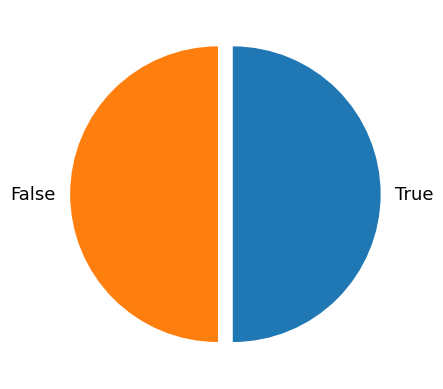

In [4]:
plt.rcParams.update({'font.size': 13})
label = ['True', 'False']
count = [len(df[df['humor']==True]),
         len(df[df['humor']==False])]

plt.pie(count, labels = label,startangle=-90, explode=[0.1,0])
plt.show()

The data is evenly split: 100000 True and 100000 False

In [6]:
def custom_tokenizer(text):
    return regexp_tokenize(text, pattern=r"\b\w+\b")
tokenizer = get_tokenizer(custom_tokenizer)
texts = np.array(df['text'])
tokens = [tokenizer(text) for text in texts]
vocab = build_vocab_from_iterator(tokens)
vocab_size = len(vocab) + 1

Initialize the Tokenizer with basic english,then fit it to the text data and calculate the vocabulary size

In [7]:
maxlen = 15
df['humor'] = df['humor'].apply(lambda x: {True: 1, False: 0}.get(x))
sequences = [[vocab[token] for token in text] for text in tokens]
padded_sequences = np.zeros((len(sequences), maxlen), dtype=np.int64)
for i, seq in enumerate(sequences):
    if len(seq) > maxlen:
        padded_sequences[i, :] = np.array(seq[:maxlen])
    else:
        padded_sequences[i, :len(seq)] = np.array(seq)

texts = padded_sequences
texts = np.array(texts)
labels = df['humor']
labels = np.array([float(j) for j in labels])

df.head() # 0= False and 1= True

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


Set a maximum sequence length, convert humor labels to binary, tokenize and truncate/pad text sequences, and create arrays for text data and labels


In [8]:
# Step 1: Create a dictionary to store the count of occurrences for each unique word
word_counts = defaultdict(int)

# Step 2: Iterate through the DataFrame and tokenize the text
for index, row in df.iterrows():
    text, humor = row['text'], row['humor']
    if humor == True:  # Considering only humorous words
        tokens = tokenizer(text)  # Use the tokenizer you provided

        # Step 3: Update the dictionary with the count of occurrences
        for token in tokens:
            word_counts[token] += 1

# Step 4: Sort the words by their count of occurrences and display the top results
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 most humorous words by count
for word, count in sorted_words[:10]:
    print(f"{word}: {count}")

a: 57506
the: 48179
you: 30886
to: 24386
What: 24142
i: 21918
s: 20673
do: 17839
it: 17236
in: 15581


As expected a lot of basic words that are not very insighful.

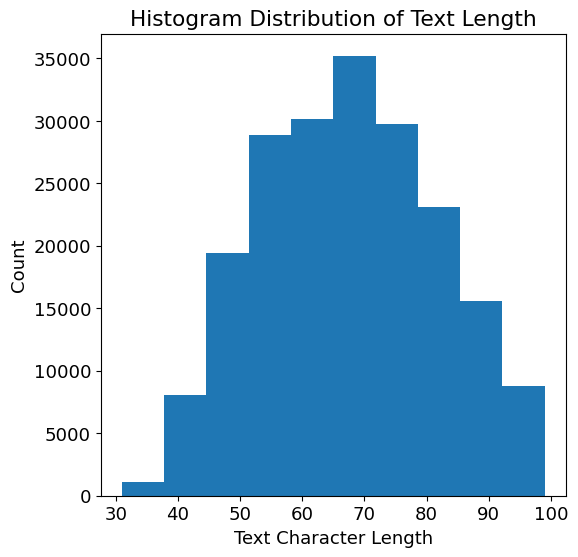

In [9]:
text_len = [len(x) for x in list(df['text'])] 

fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(text_len, bins=10)
plt.xlabel("Text Character Length")
plt.ylabel("Count")
plt.title("Histogram Distribution of Text Length")
plt.show()

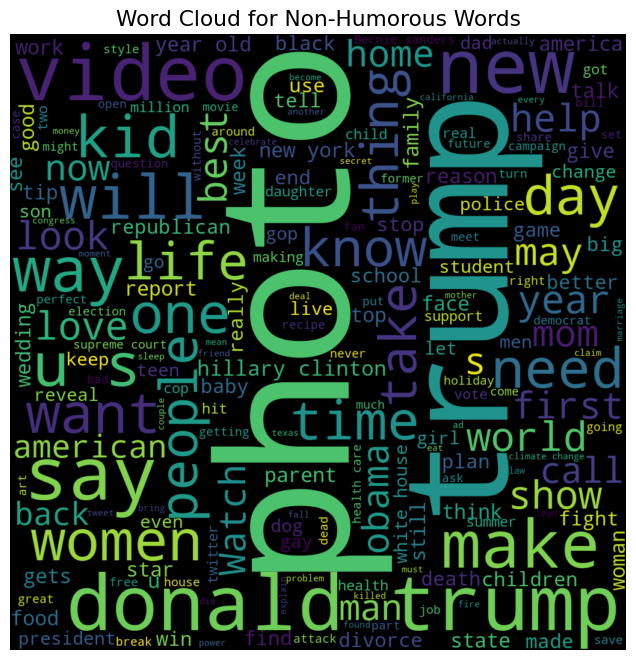

In [10]:
# List of additional stopwords to be excluded from the word cloud
list_words_add = ['none'] # wors to not include 
STOPWORDS.update(list_words_add)

all_nonhumorous_words = ''
for idx, row in df.iterrows():
    if row['humor'] == 0:
        all_nonhumorous_words += ' ' + row['text'].strip()

wc = WordCloud(width=1024, height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_nonhumorous_words)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Humorous Words')
plt.show()

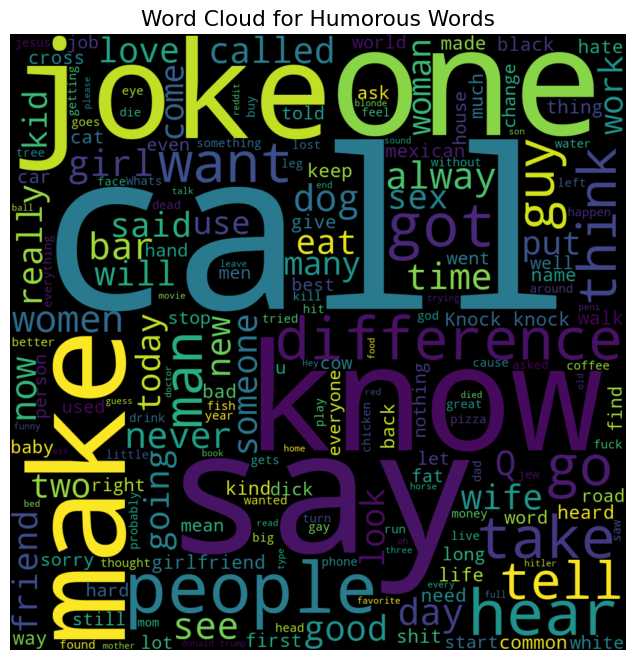

In [11]:
list_words_add = ['none']
STOPWORDS.update(list_words_add)

all_humorous_words = ''
for idx, row in df.iterrows():
    if row['humor'] == 1:
        all_humorous_words += ' ' + row['text'].strip()

wc = WordCloud(width=1024, height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_humorous_words)

# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Humorous Words')
plt.show()

In [12]:
all_humorous_words[0:500]

" What do you call a turtle without its shell? dead. What is a pokemon master's favorite kind of pasta? wartortellini! Why do native americans hate it when it rains in april? because it brings mayflowers. My family tree is a cactus, we're all pricks. How are music and candy similar? we throw away the rappers. I just ended a 5 year relationship i'm fine, it wasn't my relationship :p Dating tip: surprise your date! show up a day early. What do you call an explanation of an asian cooking show? a wok"

In [13]:
# Creating the Embedding Matrix
embedding_dim = 100

embedding_matrix = torch.rand(vocab_size, embedding_dim)

print("Shape of the embedding matrix:", embedding_matrix.shape)

Shape of the embedding matrix: torch.Size([72279, 100])


In [14]:
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [15]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_prob):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)
        output = self.fc1(pooled)
        output = F.relu(output)
        output = self.fc2(output)
        return output.squeeze(1)

# Create an instance of the model with specified parameters
hidden_dim = 64
dropout_prob = 0.2
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, dropout_prob)

In [16]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Convert the data to PyTorch tensors
x_train_tensor = torch.LongTensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_val_tensor = torch.LongTensor(x_val)
y_val_tensor = torch.Tensor(y_val)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Assuming you have defined a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 20
best_accuracy = 0

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).long()

# Create DataLoader objects for the training and validation sets
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=4096)

val_data = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_data, batch_size=4096)

In [ ]:
# Initialize lists to store the accuracy and loss values for training and validation
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()  
    correct_train = 0
    total_train = 0
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
        loss.backward()
        optimizer.step()
    train_accuracies.append(correct_train / total_train)
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()  
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
        val_accuracies.append(correct_val / total_val)
        val_losses.append(val_loss / len(val_loader))

The model was trained for 20 epochs, and during the training process, we can observe that both the training loss and validation loss decreased. This indicates that the model was learning effectively from the data. Moreover, the training and validation accuracies increased, reaching around 93.11% and 93.44%, respectively, by the end of the training. This suggests that the model has a good performance in predicting humor based on the given text data.

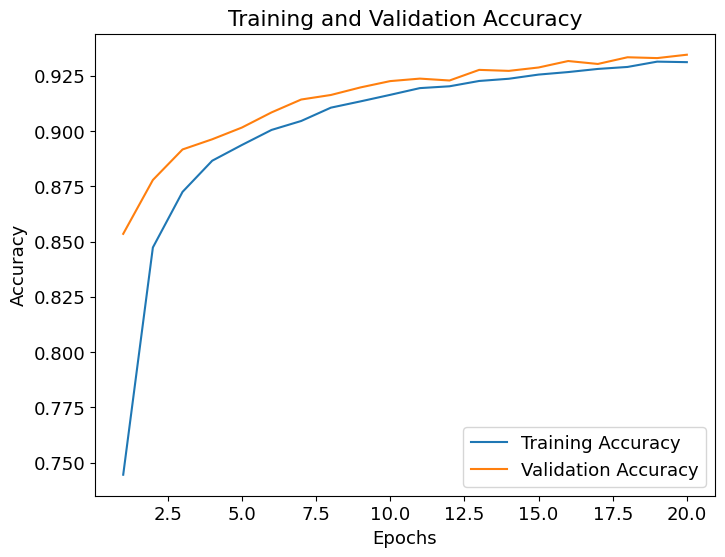

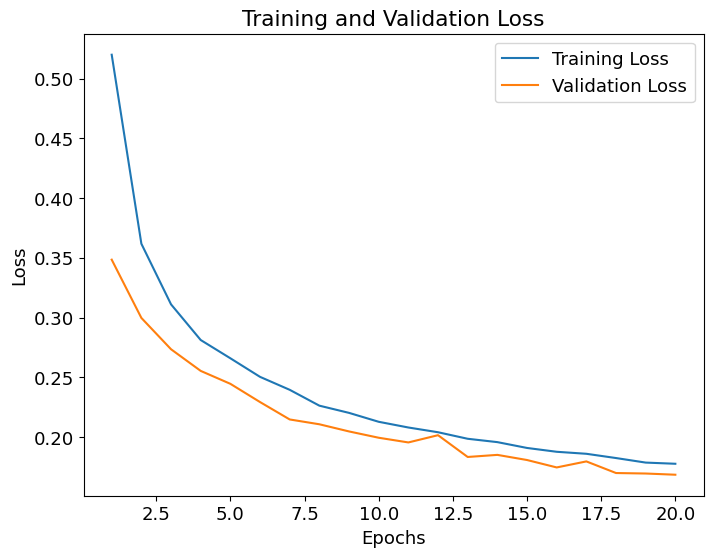

In [16]:
# Get the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the test set and display the precision, recall, f1-score, and accuracy for each class (humorous and non-humorous)

decode_label = {0: 'False', 1: 'True'}

y_pred = []
y_true = []

pred = model.predict(x_val)
pred = np.argmax(pred, axis=-1)

y_pred = [decode_label[int(i)] for i in pred]
y_true = [decode_label[int(i)] for i in y_val]

print(classification_report(y_true, y_pred, digits=3))

1250/1250 [==============================] - 14s 11ms/step
              precision    recall  f1-score   support

       False      0.929     0.941     0.935     20001
        True      0.940     0.928     0.934     19999

    accuracy                          0.934     40000
   macro avg      0.935     0.934     0.934     40000
weighted avg      0.935     0.934     0.934     40000



The evaluation of the model on the test set shows high precision, recall, and f1-score for both the humorous (True) and non-humorous (False) classes, with values around 0.92 to 0.94. The overall accuracy of the model is 93.4%, indicating that it performs well in classifying text as humorous or non-humorous. The macro and weighted averages of the precision, recall, and f1-score are also around 0.935, further confirming the model's good performance on the test data.

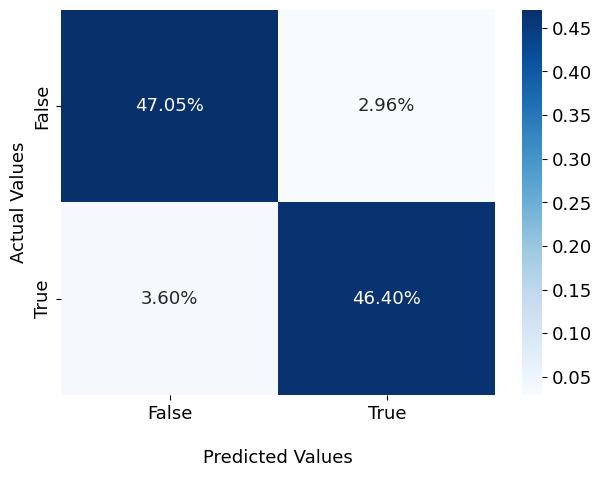

In [18]:
# Plot a confusion matrix heatmap for the model's predictions, displaying the percentage of correctly and incorrectly classified instances for humorous and non-humorous classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))

ax = sns.heatmap(cm / np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

plt.show()

The model correctly classified 47.05% of the non-humorous instances (True Negative, TN) and 46.40% of the humorous instances (True Positive, TP).
The model misclassified 2.96% of the instances as humorous when they were actually non-humorous (False Positive, FP), and 3.60% of the instances as non-humorous when they were actually humorous (False Negative, FN).
The confusion matrix shows that the model has a relatively low rate of misclassification, which is consistent with the high precision, recall, and f1-score values observed earlier.

In [19]:
# Define a function to preprocess input text, make predictions using the trained model, and return the predicted humor label (True or False)

def predict(text):
    text = tokenizer.texts_to_sequences([text])
    if len(text) > maxlen:
        text = text[:maxlen]
    text = pad_sequences(text, maxlen=maxlen, dtype='float', padding='post', value=0.0)
    text = np.array(text)
    pred = model.predict(text)
    pred = np.argmax(pred, axis=-1)
    decode_label = {0: 'False', 1: 'True'}
    pred = decode_label[pred[0]]
    return pred

In [26]:
text = "If you live each day as if it was your last, some day you'll most certainly be right." #Steve Jobs
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 155ms/step
Text: If you live each day as if it was your last, some day you'll most certainly be right.
Humor detected:  True


In [27]:
text = "he cat slept peacefully on the warm windowsill, enjoying the afternoon sun."
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 19ms/step
Text: he cat slept peacefully on the warm windowsill, enjoying the afternoon sun.
Humor detected:  False


In [28]:
text = "The diligent gardener carefully pruned the rose bushes, creating a beautiful and well-manicured garden."
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 27ms/step
Text: The diligent gardener carefully pruned the rose bushes, creating a beautiful and well-manicured garden.
Humor detected:  False


In [29]:
text = "I told my wife she was drawing her eyebrows too high; she looked surprised."
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 19ms/step
Text: I told my wife she was drawing her eyebrows too high; she looked surprised.
Humor detected:  True


In [30]:
text = "Why don't some couples go to the gym? Because some relationships don't work out!"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 21ms/step
Text: Why don't some couples go to the gym? Because some relationships don't work out!
Humor detected:  True


In [32]:
text = "Did you see the magnificent sunset tonight? The colors were absolutely breathtaking!" #no-humor
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 38ms/step
Text: Did you see the magnificent sunset tonight. The colors were absolutely breathtaking.
Humor detected:  True


It looks like you can fool the model with sentences that have the same structure as a joke (question and answer). 

In [33]:
text = "Three elephants fell off a cliff, which was quite a surprise, considering it was a calendar"
pred = predict(text)
print("Text:",text)
print('Humor detected: ',pred)

1/1 [==============================] - 0s 20ms/step
Text: Three elephants fell off a cliff, which was quite a surprise, considering it was a calendar
Humor detected:  True


In this notebook, we have successfully implemented a deep learning model to detect humor in text. We preprocessed the text data, tokenized it, and created an embedding matrix for the words. We then built, trained, and evaluated a Bi-directional LSTM model, achieving high precision, recall, and f1-score values. Finally, we created a function to make predictions on new text inputs, allowing us to apply our trained model to real-world applications.

With the promising results obtained from this notebook, further improvements could be explored, such as fine-tuning the model's hyperparameters, incorporating additional features, or experimenting with different model architectures.